In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import re

In [2]:
# Leer el archivo CSV
Pob = pd.read_csv("Estructura Población.csv")
# Filtrar para incluir solo datos de España y sexos específicos
Pob = Pob[(Pob['Economy Label'].isin(['France', "United Kingdom", 'United States of America', 'Japan', 'Germany', 'Germany, Federal Republic of', 'Italy', 'Canada', 'BRICS'])) & 
                              (Pob['Sex Label'].isin(['Both sexes']))]

C:\Users\manue\AppData\Local\Temp\ipykernel_7340\3466237048.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  Pob = pd.read_csv("Estructura Población.csv")


In [3]:
Pob = Pob[['Year', 'Economy Label', 'Sex Label', 'AgeClass Label', 'Absolute value in thousands']]

In [4]:
Pob = Pob[Pob['AgeClass Label'] != 'All age classes']

In [5]:
#Borramos los NA, porque son, o los de Alemania antes de la caída del Muro de Berlín, o los de la RFA después de ese mismo año
Pob = Pob.dropna()

In [6]:
Pob['Economy Label'] = Pob['Economy Label'].replace('Germany, Federal Republic of', 'Germany')

In [7]:
# Multiplicar los valores float64 de la columna "Absolute value in thousands" por 1000 y convertirlos en int64
Pob['Absolute value in thousands'] = Pob['Absolute value in thousands'].apply(lambda x: int(x * 1000) if isinstance(x, float) else x)

In [8]:
# Función para convertir el formato de edad
def convertir_formato(edad):
    # Utilizar expresiones regulares para extraer los números
    numeros = re.findall(r'\d+', edad)
    # Formatear los números extraídos como deseas
    if len(numeros) == 2:
        return f"{numeros[0].zfill(2)}-{numeros[1].zfill(2)}"
    else:
        return edad  # En caso de que no se pueda extraer correctamente, retornar la edad sin cambios

In [9]:
# Aplicar la función a la columna 'AgeClass Label'
Pob['AgeClass Label'] = Pob['AgeClass Label'].apply(convertir_formato)

In [10]:
# Pivotar la tabla para tener los años como columnas y el resto de los datos como índices
df_pivoted = Pob.pivot_table(
    index=['Economy Label', 'Sex Label', 'AgeClass Label'],
    columns='Year',
    values='Absolute value in thousands'
).reset_index()

In [11]:
df_pivoted.loc[df_pivoted['Economy Label'] != 'BRICS', 'Economy Label'] = 'G7'

In [12]:
sum_by_group = df_pivoted.groupby(['Economy Label', 'AgeClass Label', 'Sex Label']).sum().reset_index()

In [13]:
# Cambiar el nombre de las columnas
sum_by_group.columns.name = None

In [14]:
# Agregar una columna para el género
sum_by_group['Gender'] = sum_by_group['Sex Label']

In [15]:
# Eliminar la columna 'Sex Label'
sum_by_group.drop(columns='Sex Label', inplace=True)

In [16]:
#Borramos la columna "Gender" por estar duplicada
sum_by_group.drop(columns='Gender', inplace=True)

In [17]:
# Convertir las columnas de año a int64
year_columns = sum_by_group.columns[3:]  # Asumiendo que las primeras 3 columnas son índices y la última es 'Gender'
sum_by_group[year_columns] = sum_by_group[year_columns].astype('int64')

In [18]:
#Reordenación de filas según edad
sum_by_group = sum_by_group.sort_values(by='AgeClass Label')

In [19]:
#Reseteamos el índice
sum_by_group = sum_by_group.reset_index(drop=True)

In [20]:
# Renombrar las columnas
sum_by_group = sum_by_group.rename(columns={'Economy Label': 'Country Name', 'AgeClass Label': 'Series Name'})

In [21]:
#volvemos al nombre original
Pob = sum_by_group

In [22]:
#Convertimos las columnas a tipo string
Pob.columns = Pob.columns.astype(str)

In [23]:
# Nos aseguramos de que 'yearsLst' contiene los nombres de las columnas como strings.
yearsLst = [str(year) for year in range(1950, 2050)]

In [24]:
# Agrupar y sumar los valores por 'Economy Label' y 'AgeClass Label'
grouped = Pob.groupby(['Country Name', 'Series Name']).sum()

# Sumar los valores por 'Economy Label' para obtener el total por cada año
totals = grouped.groupby('Country Name').sum()

# Calcular el porcentaje de cada valor respecto al total por cada año
percentages = grouped.div(totals, level='Country Name') * 100

# Resetear el índice para una visualización más clara
percentages = percentages.reset_index()

Pob_rel = percentages

In [25]:
# Modifica los valores en 'yearsLst' para las filas donde el 'Gender' es "Female"
Pob_rel.loc[Pob_rel['Country Name'] == "G7", yearsLst] = Pob_rel[yearsLst].apply(lambda x: -x)

In [26]:
# Prepara los datos para la animación
def prepare_data(df, years):
    data = []
    for year in years:
        temp_df = df[['Series Name', 'Country Name', year]].copy()
        temp_df = temp_df.rename(columns={year: 'Population'})
        temp_df['Year'] = year
        data.append(temp_df)
    return pd.concat(data)

animated_data = prepare_data(Pob_rel, yearsLst)

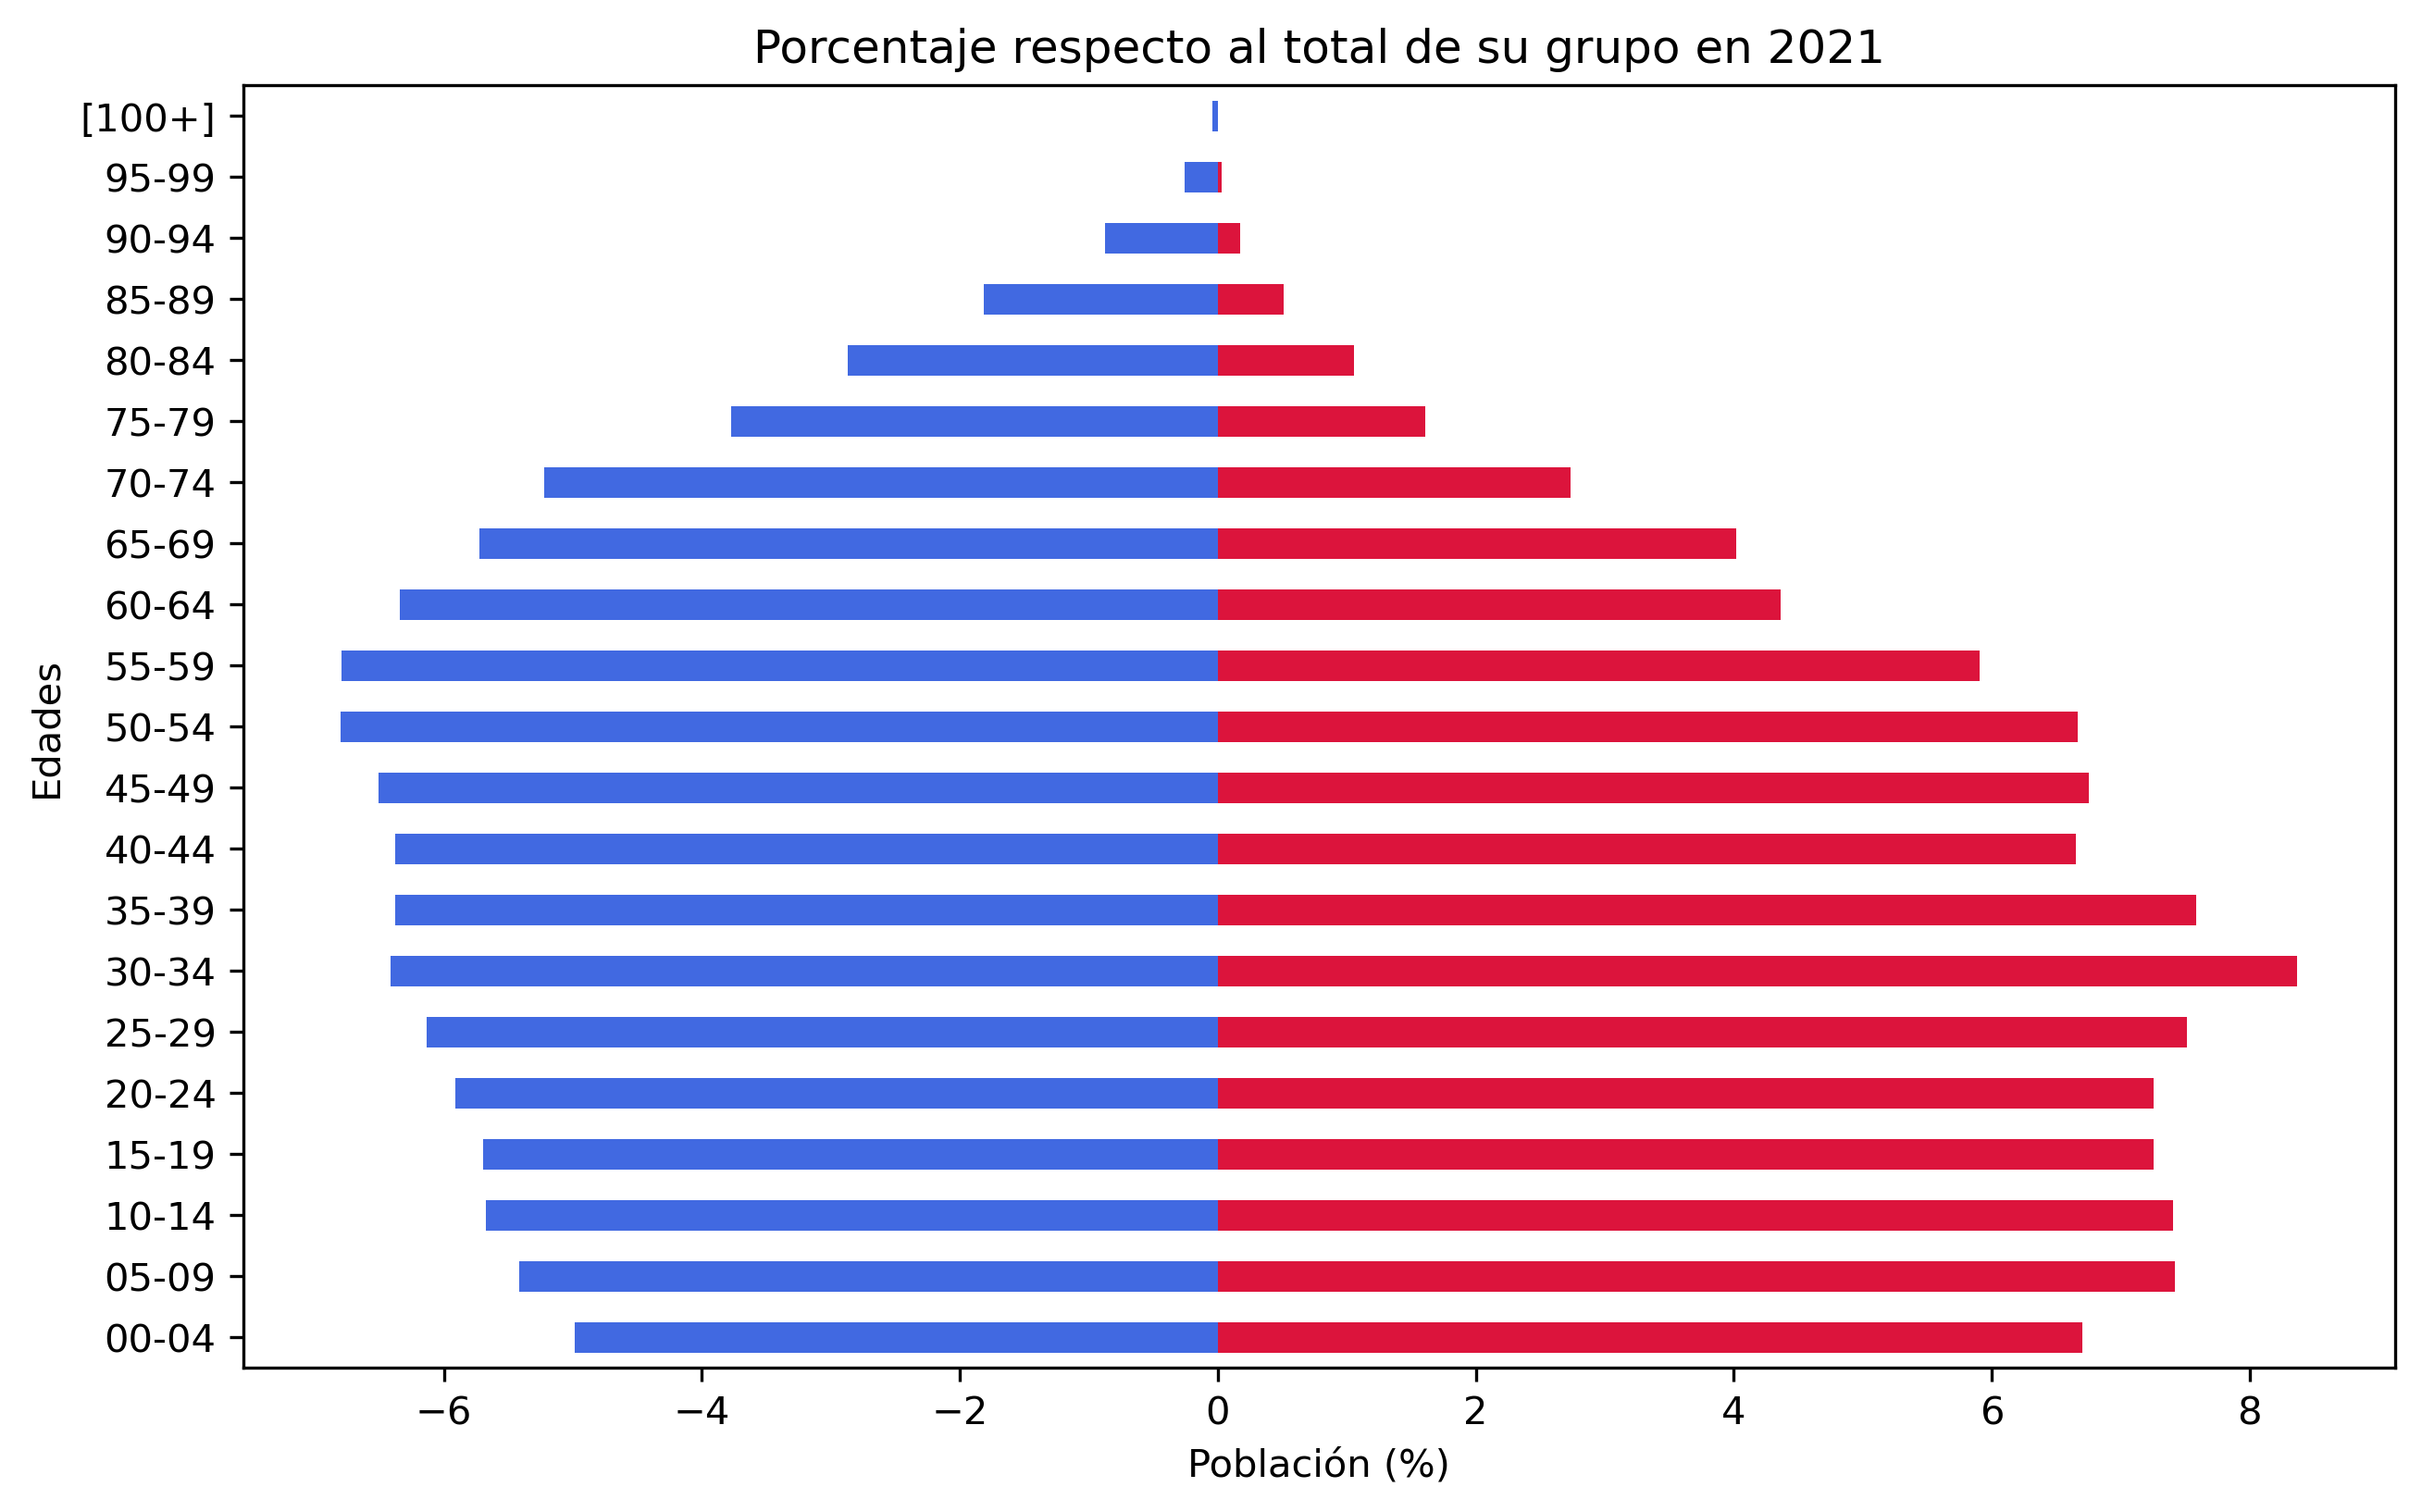

In [27]:
import matplotlib.pyplot as plt

# Configurar la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)

# Filtrar los datos para el año 2021
year_data = animated_data[animated_data['Year'] == "2021"]

# Crear la gráfica de barras horizontal apilada
year_data.pivot(index='Series Name', columns='Country Name', values='Population').plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=['crimson', 'royalblue']
)

# Configurar el título y etiquetas
ax.set_title('Porcentaje respecto al total de su grupo en 2021')
ax.set_xlabel('Población (%)')
ax.set_ylabel('Edades')

# Remover la leyenda si existe
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Guardar la gráfica como PNG con fondo transparente
plt.savefig('Pob_rel_2021.png', format='png', transparent=True)

# Mostrar la gráfica
plt.show()


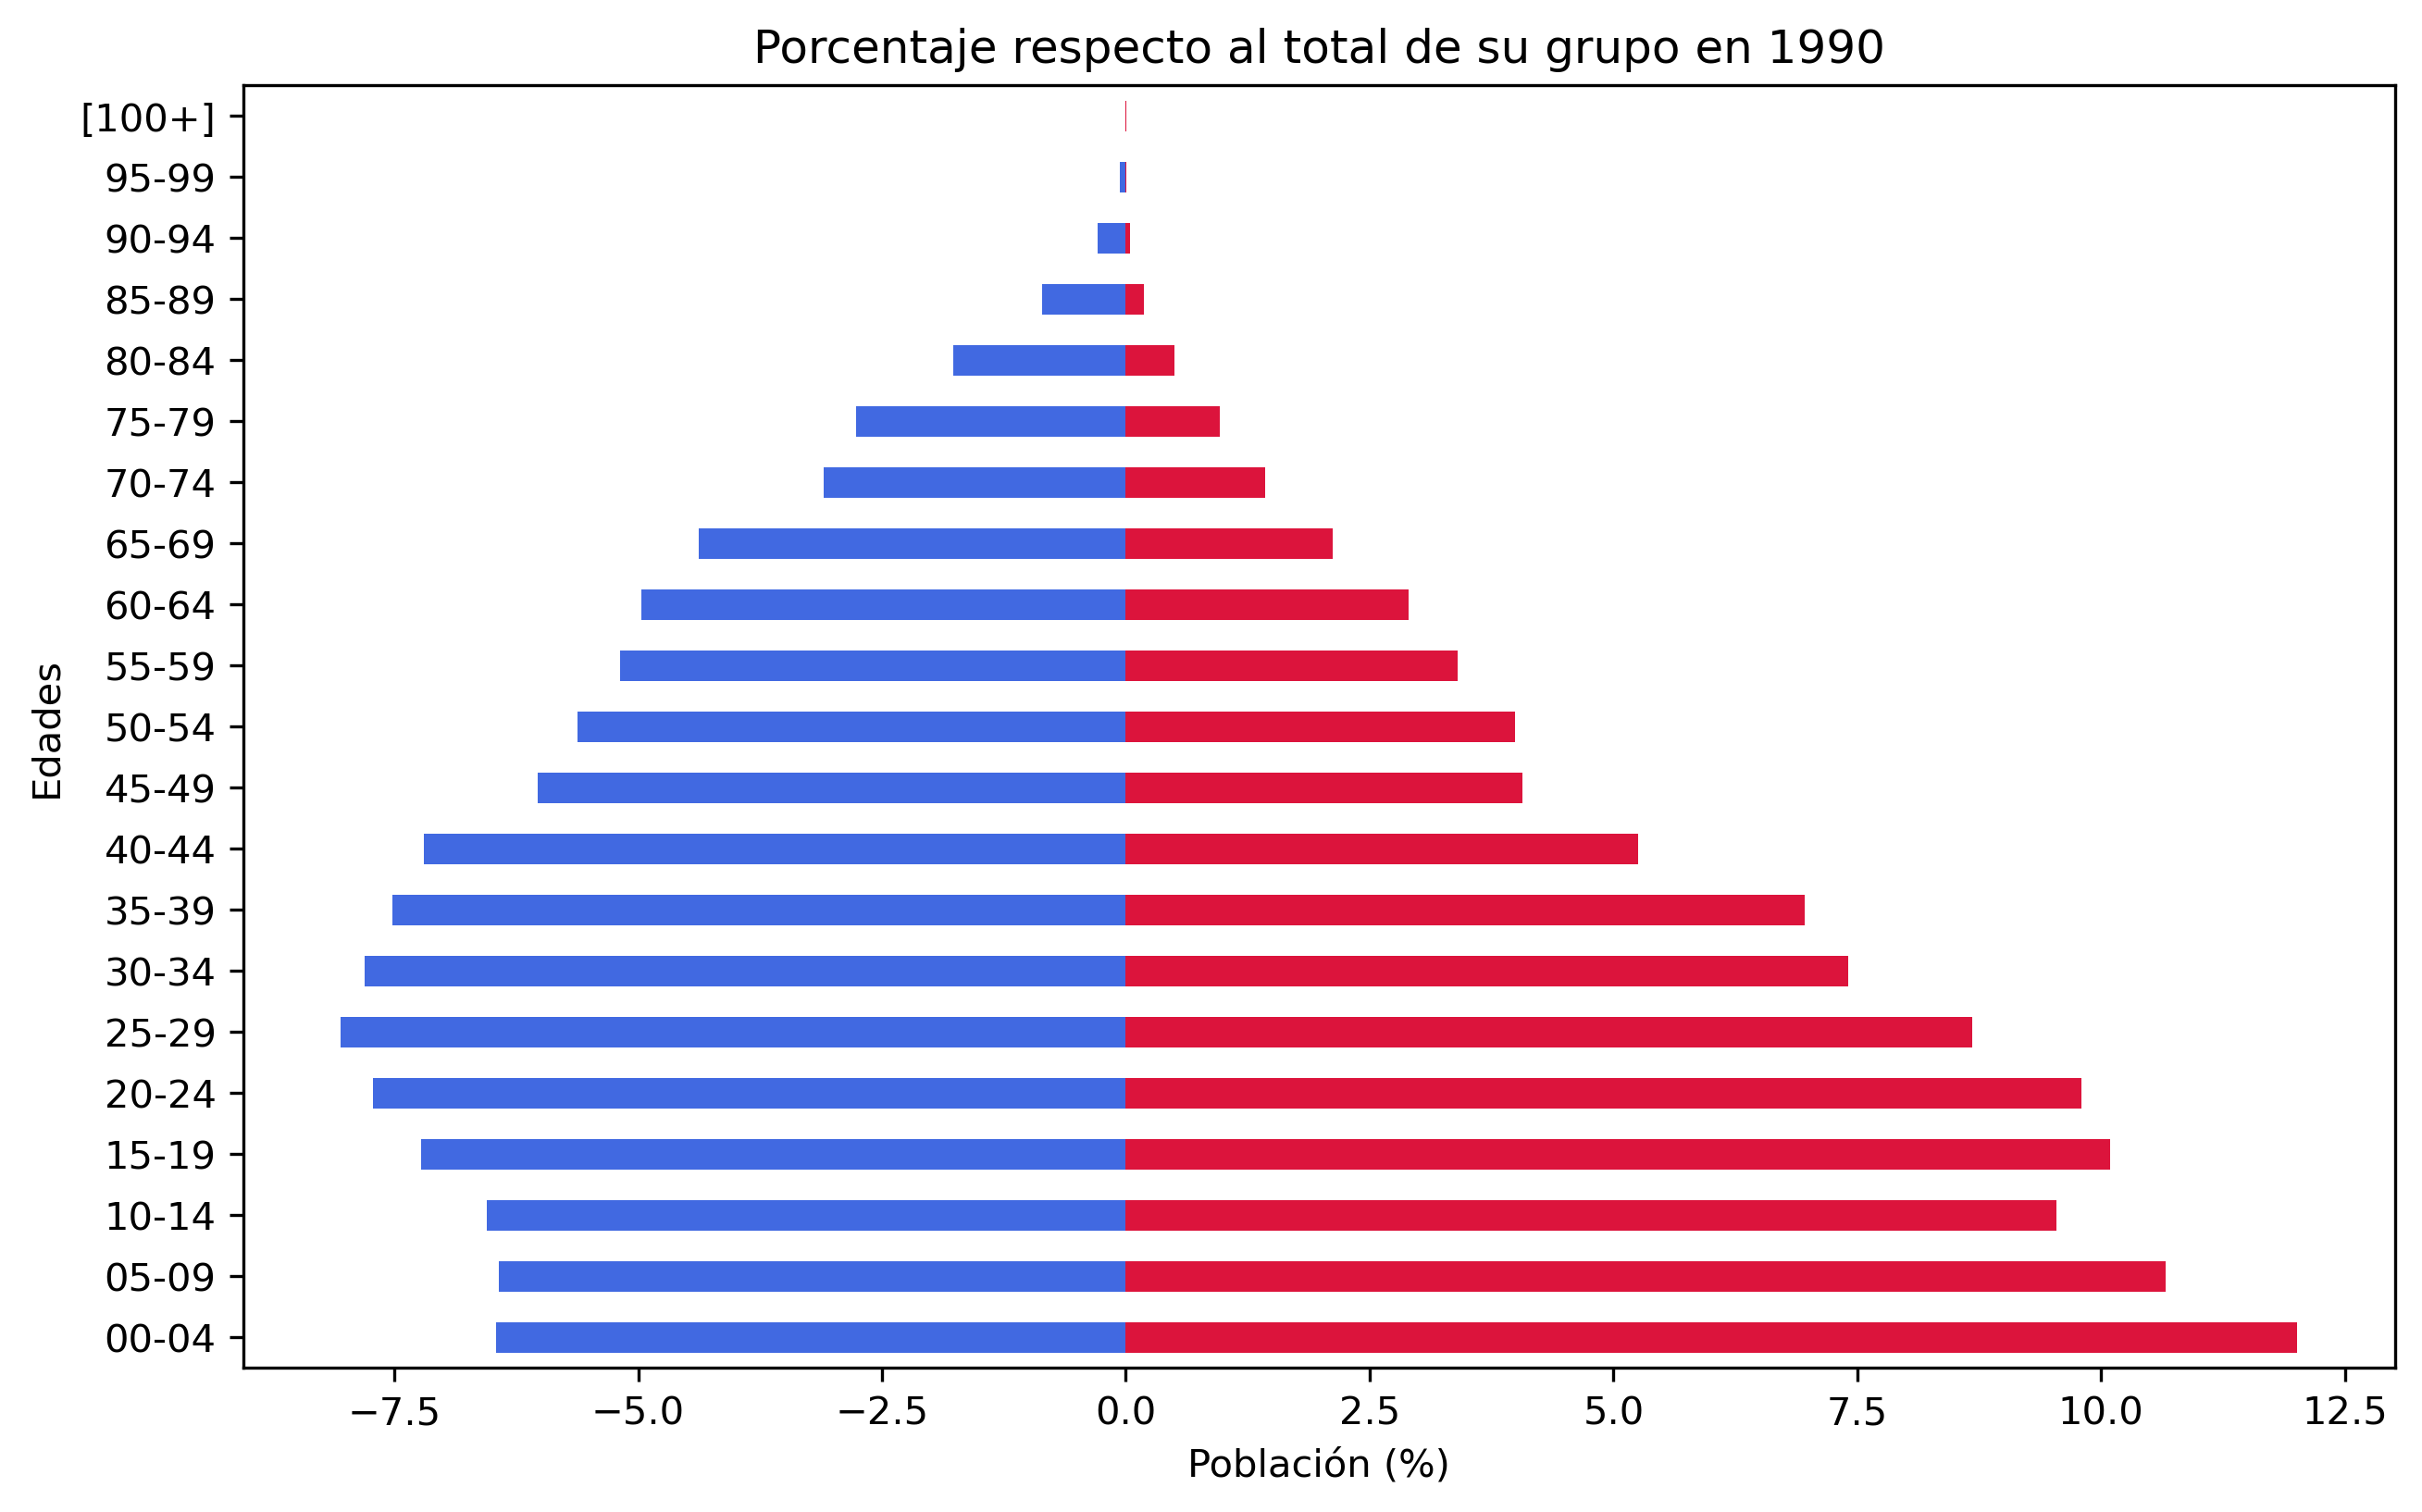

In [28]:
import matplotlib.pyplot as plt

# Configurar la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)

# Filtrar los datos para el año 2021
year_data = animated_data[animated_data['Year'] == "1990"]

# Crear la gráfica de barras horizontal apilada
year_data.pivot(index='Series Name', columns='Country Name', values='Population').plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=['crimson', 'royalblue']
)

# Configurar el título y etiquetas
ax.set_title('Porcentaje respecto al total de su grupo en 1990')
ax.set_xlabel('Población (%)')
ax.set_ylabel('Edades')
# Remover la leyenda si existe
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Guardar la gráfica como PNG con fondo transparente
plt.savefig('Pob_rel_1990.png', format='png', transparent=True)

# Mostrar la gráfica
plt.show()


In [29]:
import pandas as pd

# Supongamos que ya tienes tu DataFrame llamado Pob
# Pob = pd.read_csv('tu_archivo.csv')  # Si estuvieras leyendo desde un archivo CSV

# Filtrar el DataFrame para que solo contenga filas donde 'Country Name' es 'BRICS'
Pob_BRICS = Pob[Pob['Country Name'] == 'BRICS']

# Calcular la suma de todas las filas a partir de la columna 2 (índice 1 en pandas)
suma_filas = Pob_BRICS.iloc[:, 1:].sum()

# Convertir la suma en un DataFrame de una fila
suma_filas = pd.DataFrame(suma_filas).transpose()

# Añadir la columna 'Country Name' con el valor 'Total'
suma_filas['Country Name'] = 'Total'

# Reordenar las columnas para que 'Country Name' esté al principio
columnas = ['Country Name'] + Pob_BRICS.columns.tolist()[1:]
suma_filas = suma_filas[columnas]

# Concatenar el DataFrame filtrado con la fila de suma
df_final = pd.concat([Pob_BRICS, suma_filas], ignore_index=True)

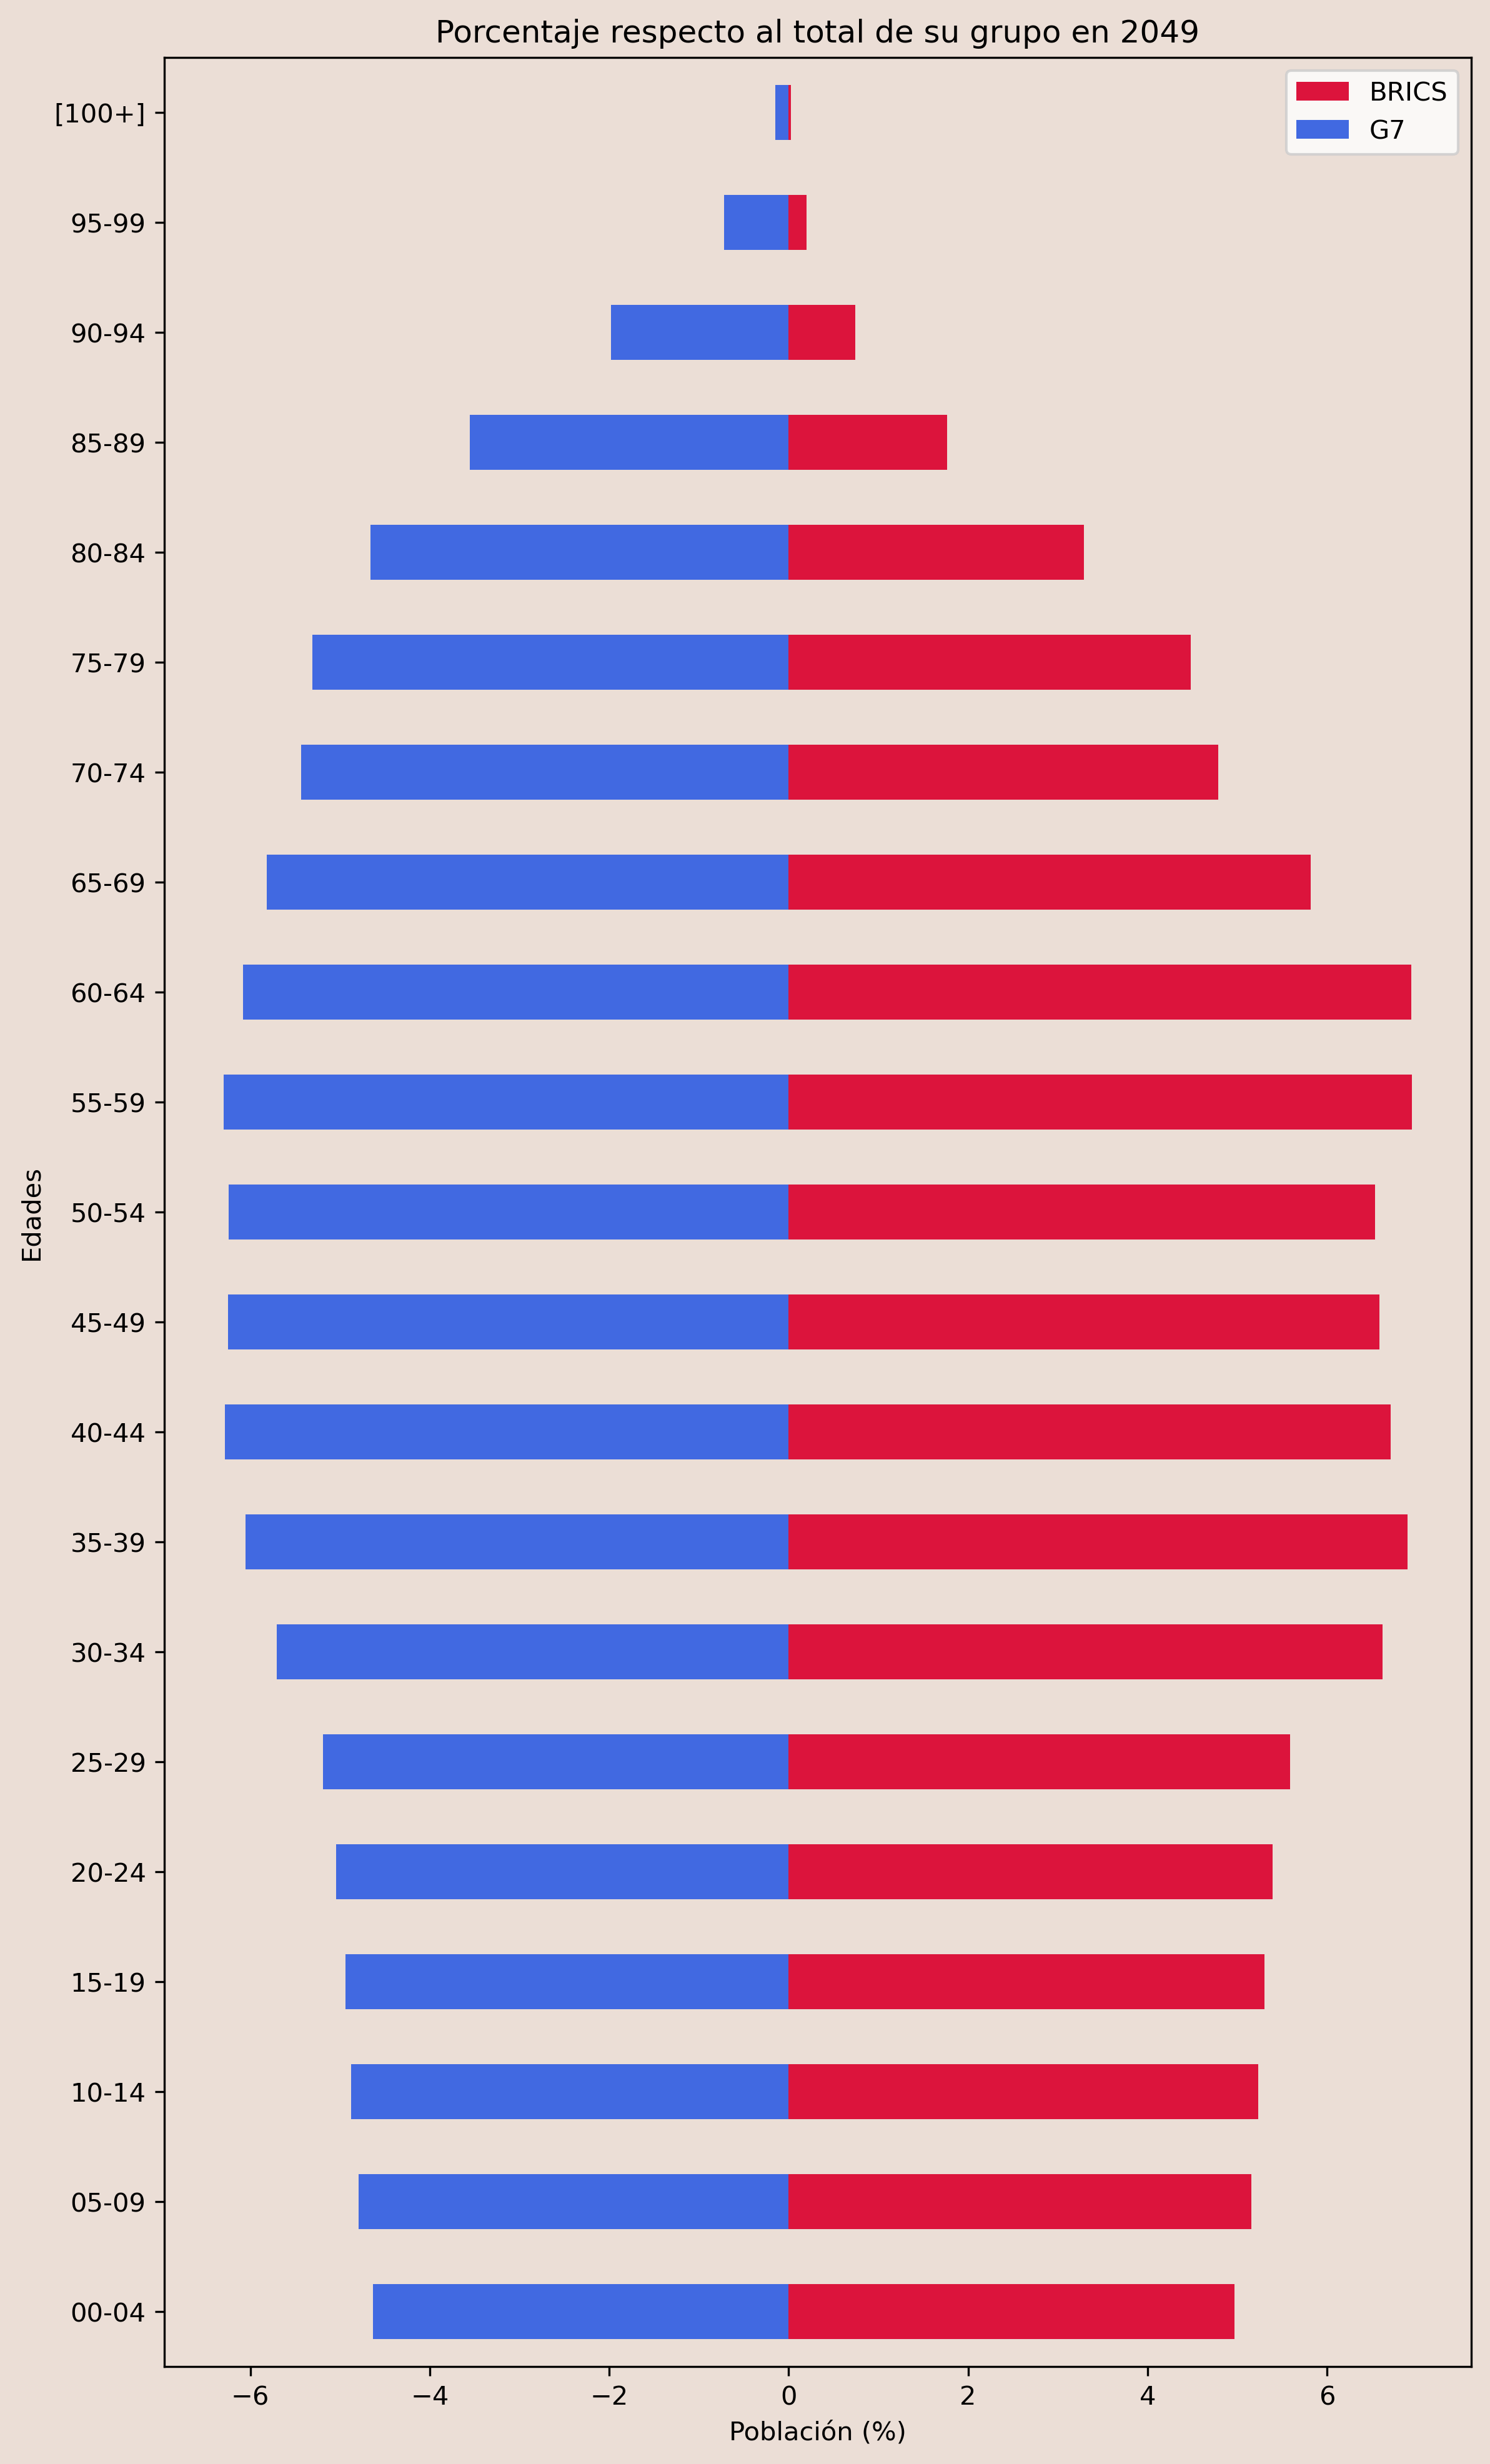

In [30]:
import matplotlib.pyplot as plt
from matplotlib import animation

# Configurar la figura y el eje
fig, ax = plt.subplots(figsize=(9, 16), dpi=300)

fig.patch.set_facecolor('#ebded6')
ax.set_facecolor('#ebded6')

def update(year):
    ax.clear()
    year_data = animated_data[animated_data['Year'] == year]
    year_data.pivot(index='Series Name', columns='Country Name', values='Population').plot(
        kind='barh', stacked=True, ax=ax, color=['crimson', 'royalblue']
    )
    ax.set_title(f'Porcentaje respecto al total de su grupo en {year}')
    ax.set_xlabel('Población (%)')
    ax.set_ylabel('Edades')
    ax.legend(["BRICS", "G7"])

# Crear la animación
frames = len(yearsLst)
fps = frames / 18

ani = animation.FuncAnimation(fig, update, frames=yearsLst, repeat=False)

# Guardar la animación como MP4
ani.save('Pob_rel.mp4', writer='ffmpeg', fps=fps)

plt.show()